<a href="https://colab.research.google.com/github/Rabia-Akhtr/Time-Series-Modelling-Case-Study/blob/main/Time_Series_Modelling_Case_Study_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [7, 5]


# **Load and Read the Data**

In [2]:
# Load data
data = pd.read_csv('/content/drive/MyDrive/Advance Research/Assignment 1/oil_price.csv')

# Preview data
data.head()

,Date,Price
0,"Jul 01, 2020",42.18
1,"Jul 02, 2020",43.19
2,"Jul 03, 2020",42.92
3,"Jul 06, 2020",42.73
4,"Jul 07, 2020",43.28


In [3]:
print(data.columns.tolist())

['Date', 'Price']


In [4]:
data.tail()

,Date,Price
1225,NaN,NaN
1226,NaN,NaN
1227,NaN,NaN
1228,NaN,NaN
1229,NaN,NaN


In [5]:
data = data.dropna()

In [6]:
# Read data
pd.concat([data.head(), data.tail()])

,Date,Price
0,"Jul 01, 2020",42.18
1,"Jul 02, 2020",43.19
2,"Jul 03, 2020",42.92
3,"Jul 06, 2020",42.73
4,"Jul 07, 2020",43.28
630,"Dec 22, 2022",79.58
631,"Dec 23, 2022",82.45
632,"Dec 28, 2022",81.70
633,"Dec 29, 2022",80.96
634,"Dec 30, 2022",82.82


In [7]:
# Null values
data.isna().sum()

,0
Date,0
Price,0


In [8]:
# Get the shape of the dataset
print(data.shape)

(635, 2)


In [9]:
print(data.describe())

            Price
count  635.000000
mean    77.214110
std     23.898162
min     36.330000
25%     61.130000
50%     75.500000
75%     94.275000
max    133.180000


In [10]:
# Convert date column
data['Date'] = pd.to_datetime(data['Date'], format='%b %d, %Y')
# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Convert 'Price' column to numeric  and drop missing rows
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
data.dropna(inplace=True)

# Preview the cleaned data
print(data.head())

            Price
Date             
2020-07-01  42.18
2020-07-02  43.19
2020-07-03  42.92
2020-07-06  42.73
2020-07-07  43.28


This is the ideal structure for ARIMA modeling ✅

# **Exploratory Data Analysis (EDA)**

# **Time Series Plot**

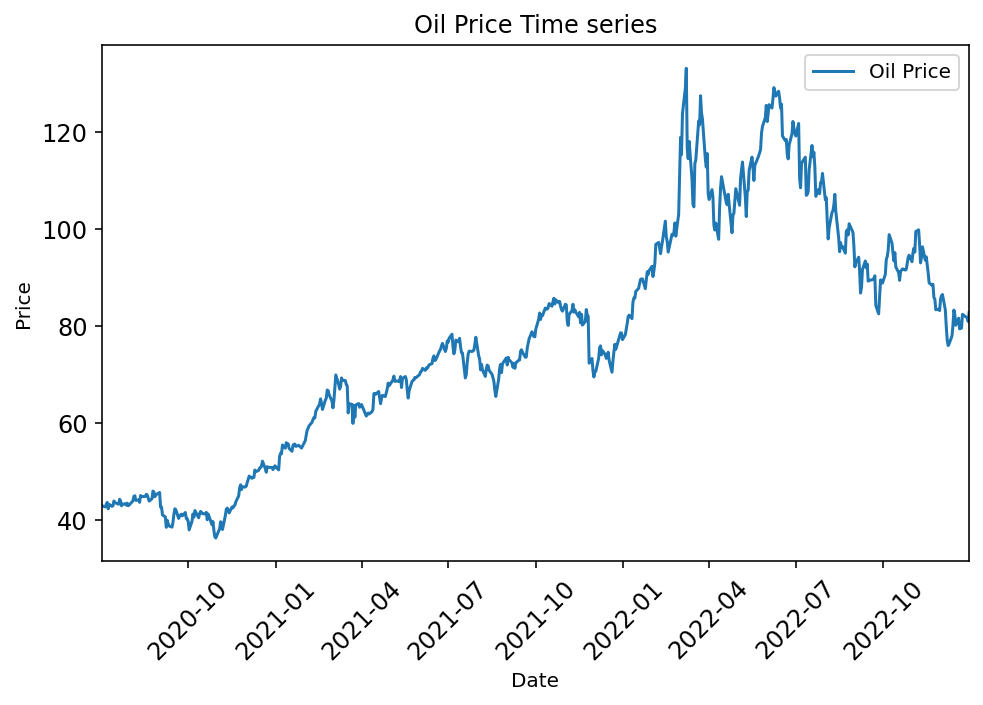

In [35]:
import matplotlib.pyplot as plt

def plot_oil_price(dataframe):
    """
    Plots the oil price time series using the index (Date) and the 'Price' column.
    """
    plt.figure(figsize=(7, 5), dpi=144)
    plt.plot(dataframe.index, dataframe['Price'], label='Oil Price')  # Use index, not 'Date'
    plt.title('Oil Price Time series')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()

    # Force x-axis range to match the actual data range
    plt.xlim(data.index.min(), data.index.max())

    plt.show()

plot_oil_price(data)


In [12]:
import matplotlib.pyplot as plt

def plot_price_distribution(df, price_col='Price', bins=30):
    """

    """
    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax_hist, ax_box) = plt.subplots(
        nrows=1, ncols=2,
        figsize=(12, 5),      # width=12 inches, height=5 inches
        dpi=144               # higher DPI for crispness
    )

    # --- Histogram on the left ---
    ax_hist.hist(
        df[price_col],        # data to plot
        bins=bins,            # number of bars
        edgecolor='black'     # black border around bars
    )
    ax_hist.set_title('Histogram of Oil Prices')   # descriptive title
    ax_hist.set_xlabel('Price')                    # x-axis label
    ax_hist.set_ylabel('Frequency')                # y-axis label

    # --- Boxplot on the right ---
    ax_box.boxplot(
        df[price_col],        # data to plot
        vert=False,           # horizontal box
        patch_artist=True     # fill box with color
    )
    ax_box.set_title('Boxplot of Oil Prices')      # descriptive title
    ax_box.set_xlabel('Price')                     # x-axis label

    # Layout tweaks
    plt.tight_layout()  # adjust subplots to fit in figure area
    plt.show()          # render the figure


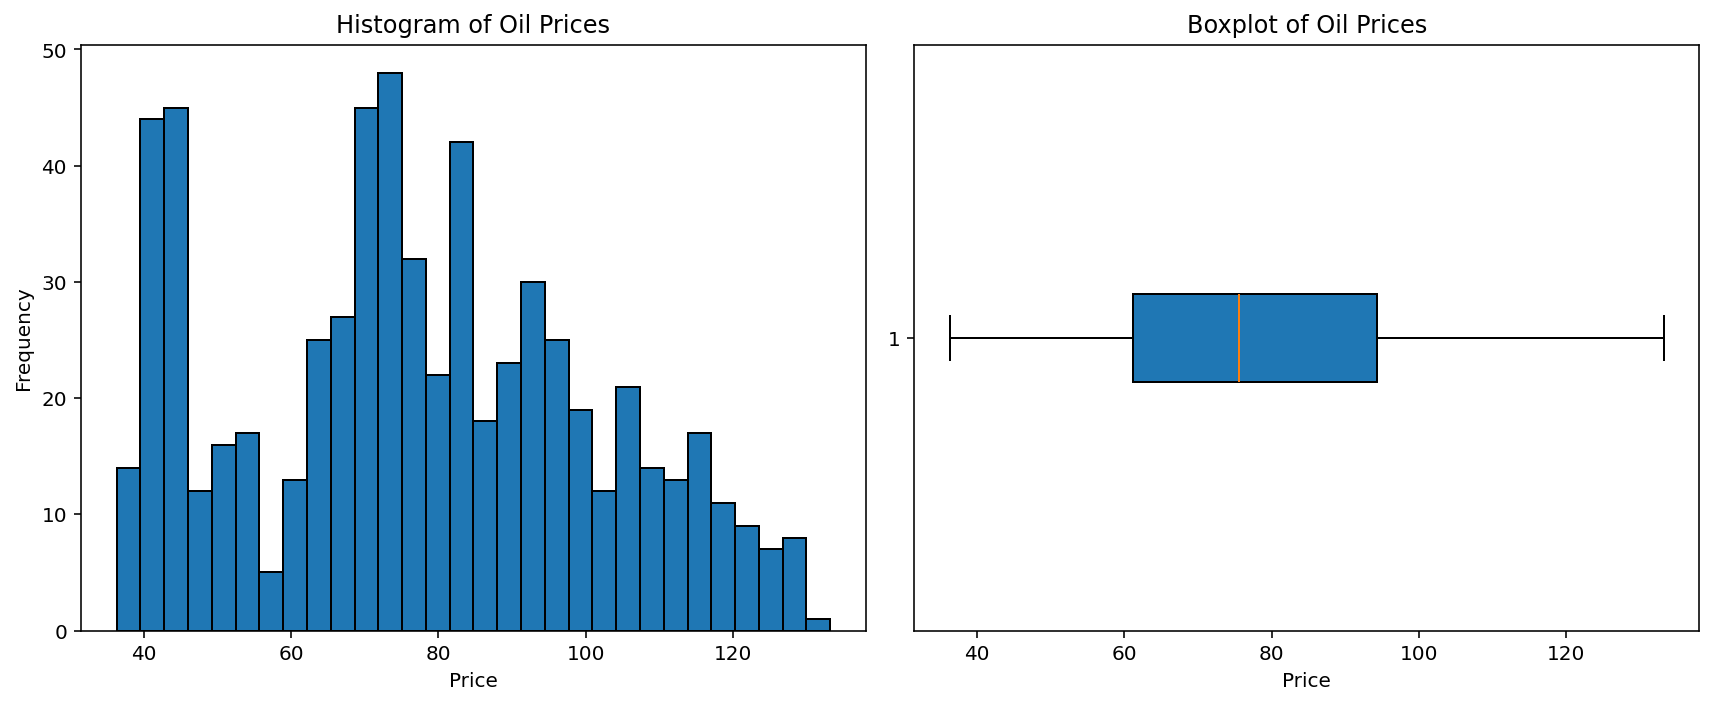

In [13]:
plot_price_distribution(data)


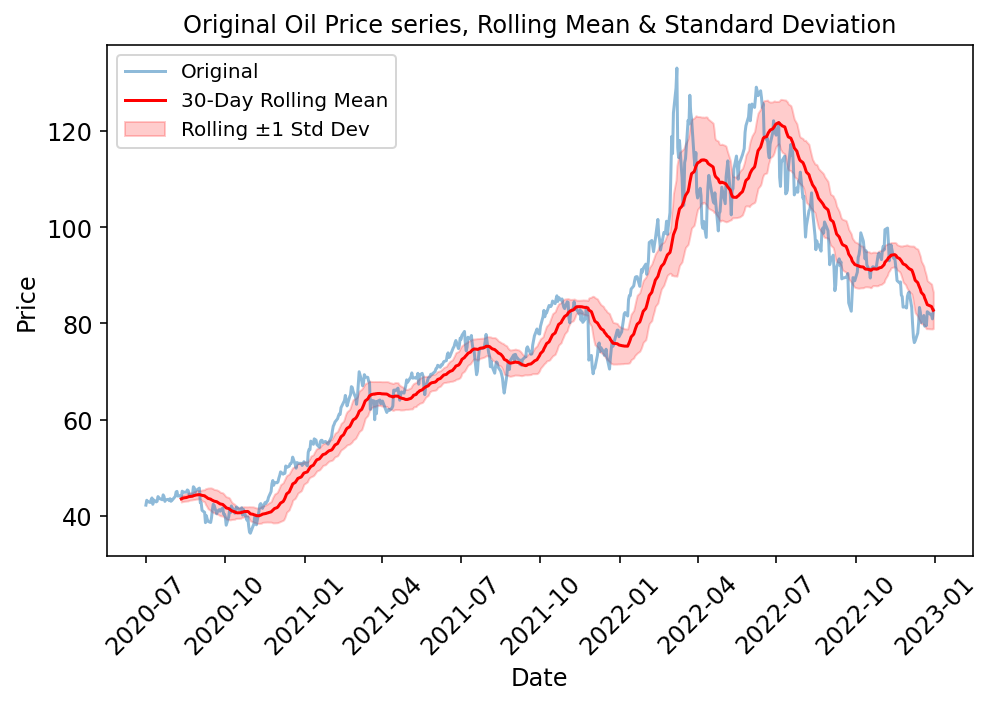

In [14]:

from statsmodels.tsa.seasonal import seasonal_decompose

# Rolling Mean ± Standard Deviation (30-day window)
window = 30
rol_mean = data['Price'].rolling(window=window).mean()
rol_std  = data['Price'].rolling(window=window).std()

plt.figure(figsize=(7, 5), dpi=144)
plt.plot(data['Price'],      label='Original', alpha=0.5)
plt.plot(rol_mean,           label=f'{window}-Day Rolling Mean', color='red')
plt.fill_between(rol_std.index,
                 rol_mean - rol_std,
                 rol_mean + rol_std,
                 color='red', alpha=0.2,
                 label='Rolling ±1 Std Dev')

plt.title('Original Oil Price series, Rolling Mean & Standard Deviation')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.tight_layout()
plt.show()



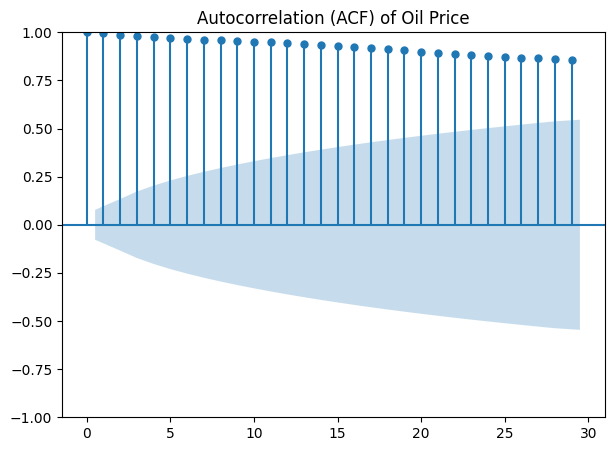

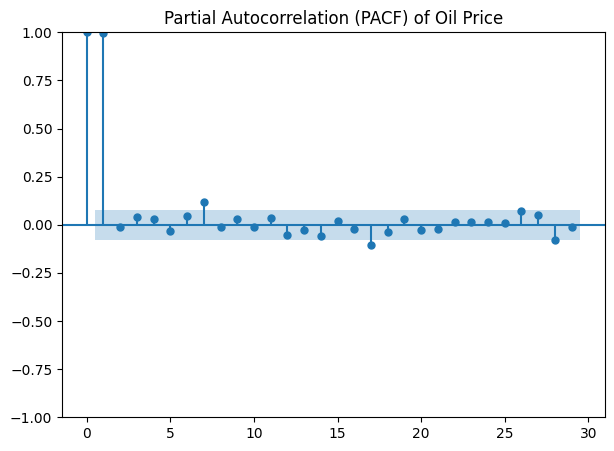

In [15]:
def plot_acf_pacf(price):
    """
    Plots the ACF and PACF of the given price data.

    Parameters:
    pandas Series (e.g., data['Price'])
    """
    # Plot ACF (Autocorrelation Function)
    plot_acf(data['Price'])
    plt.title('Autocorrelation (ACF) of Oil Price')
    plt.show()

    # Plot PACF (Partial Autocorrelation Function)
    plot_pacf(data['Price'])
    plt.title('Partial Autocorrelation (PACF) of Oil Price')
    plt.show()
    return

plot_acf_pacf(data['Price'])

ACF Plot Insight:
All bars are significantly above confidence bounds, even at high lags.

This means the series is non-stationary and needs differencing (d ≥ 1).

PACF Plot Insight:
Big spikes at lag 1 and 2, then smaller, random noise after.

Suggests that AR terms (p) of 1 or 2 might be appropriate.

# **ADF Test to check stationarity**

In [16]:
# Augmented Dickey-Fuller test on the oil price data,
result = adfuller(data['Price'])

# Print the ADF statistic and p-value
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.598608589550151
p-value: 0.48429238915100054


The oil price data is non-stationary.

The Augmented Dickey-Fuller (ADF) test on the original oil price data produced an ADF statistic of -1.60 and a p-value of 0.484. Because the p-value is significantly greater than 0.05, we fail to reject the null hypothesis that the series has a unit root. This indicates that the series is non-stationary, consistent with the high autocorrelation observed in the ACF plot.

In practical terms, this means the statistical properties of the oil price series (such as the mean and variance) are not constant over time. Therefore, further transformation (such as differencing) is required before fitting an ARMA model.

# **Make Data Stationary**

# **Box-Cox Transformation: Find the Optimal Lambda**

Why Box-Cox?

It stabilizes the variance, which helps ARIMA fit better (especially when prices grow over time).

But it doesn’t make it stationary (ADF shows it's still not enough).

In [17]:
from scipy.stats import boxcox

# Find the optimal Box-Cox transformation for the 'Price' column
data['boxcox_tr'], lam = boxcox(data['Price'])

# Print the optimal lambda
print('Optimal Lambda for Box-Cox transformation: %f' % lam)


Optimal Lambda for Box-Cox transformation: 0.616179


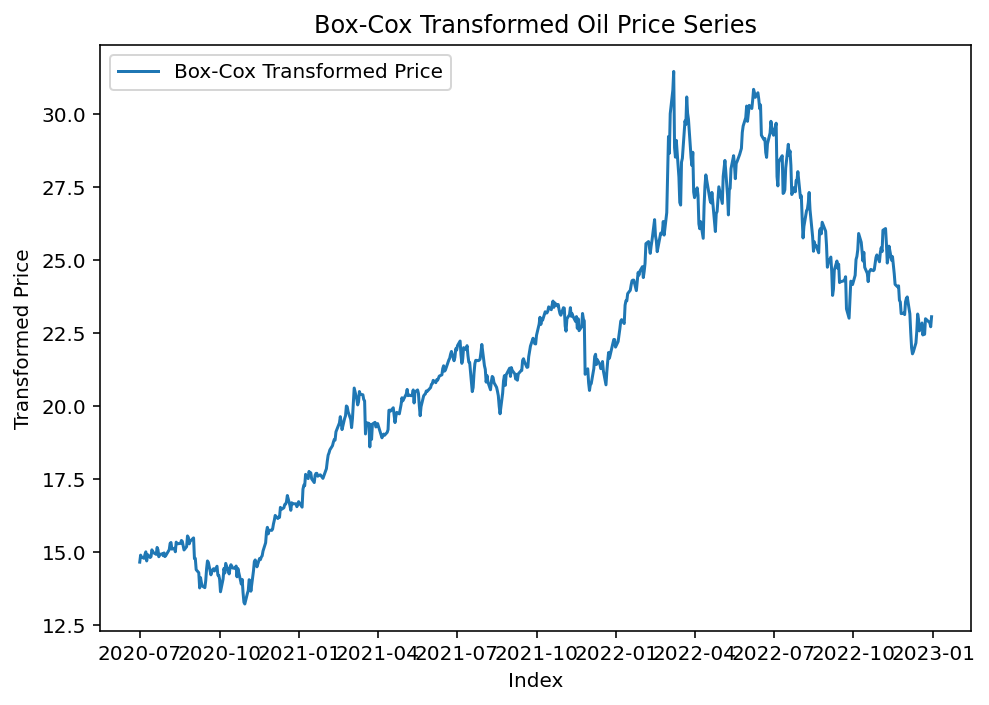

In [18]:
def plot_boxcox_transformed(series):
    """
    Plots the Box-Cox transformed time series.

    Parameters:
    pandas Series, the transformed price data
    """
    plt.figure(dpi=144)
    plt.plot(series, label='Box-Cox Transformed Price')
    plt.title('Box-Cox Transformed Oil Price Series')
    plt.xlabel('Index')
    plt.ylabel('Transformed Price')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return

plot_boxcox_transformed(data['boxcox_tr'])

In [19]:
# Take the first difference of the Box-Cox transformed oil price series
data['boxcox_tr_diff'] = data['boxcox_tr'].diff()
data.dropna(inplace=True)  # Remove first NaN
# Display the first 10 rows to show the result
print(data.head(10))


            Price  boxcox_tr  boxcox_tr_diff
Date                                        
2020-07-02  43.19  14.896040        0.239108
2020-07-03  42.92  14.832332       -0.063708
2020-07-06  42.73  14.787409       -0.044924
2020-07-07  43.28  14.917242        0.129833
2020-07-08  43.67  15.008922        0.091680
2020-07-09  42.35  14.697331       -0.311591
2020-07-10  43.27  14.914887        0.217556
2020-07-13  42.85  14.815790       -0.099097
2020-07-14  42.97  14.844142        0.028351
2020-07-15  43.96  15.076891        0.232749


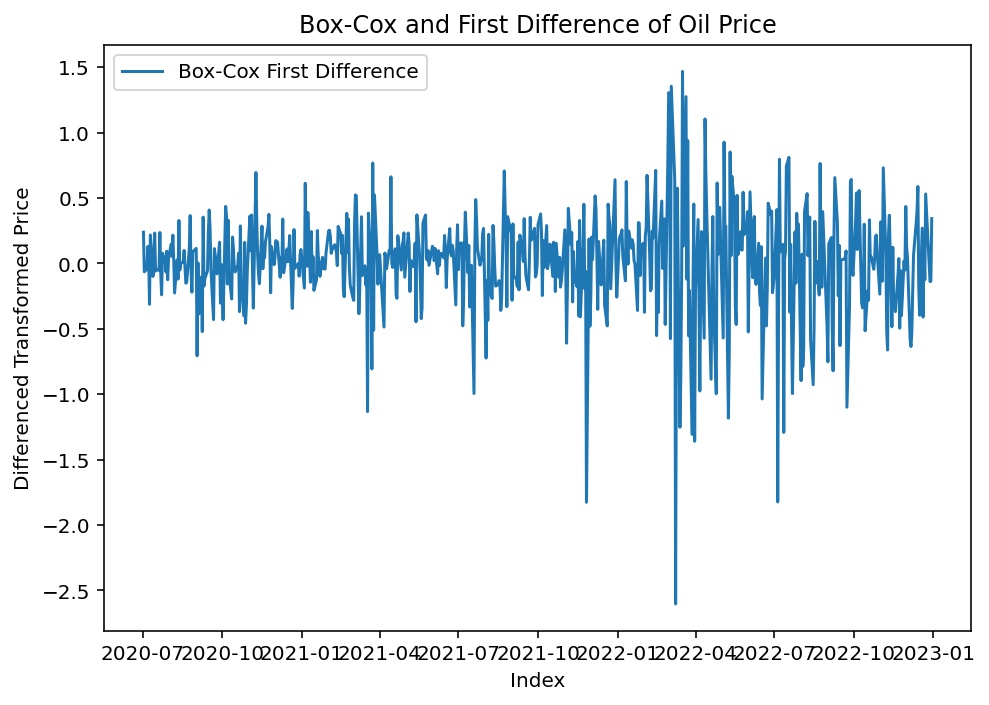

In [20]:
# Plot the first-differenced Box-Cox transformed oil price series
plt.figure(dpi=144)
plt.plot(data['boxcox_tr_diff'], label='Box-Cox First Difference')
plt.title('Box-Cox and First Difference of Oil Price')
plt.xlabel('Index')
plt.ylabel('Differenced Transformed Price')
plt.legend()
plt.tight_layout()
plt.show()

The plot of the first-differenced Box-Cox transformed oil price series shows fluctuations around a constant mean with relatively stable variance, and no visible trend or seasonality. This visual evidence, along with the ADF test result, confirms that the series is now stationary and suitable for ARMA modeling.

In [21]:
# re-run the ADF test
ad_fuller_result = adfuller(data['boxcox_tr_diff'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.235817445408586
p-value: 7.426337783787552e-06


The Augmented Dickey-Fuller (ADF) test on the Box-Cox transformed and first-differenced oil price series yielded an ADF statistic of -5.24 and a p-value of 0.0000073. Since the p-value is much smaller than 0.05, we reject the null hypothesis of a unit root and conclude that the transformed series is stationary.

This means the series now has a constant mean and variance over time, making it suitable for ARMA modeling. This successful result confirms that the combination of Box-Cox transformation and first differencing was effective in achieving stationarity.

<Figure size 1440x720 with 0 Axes>

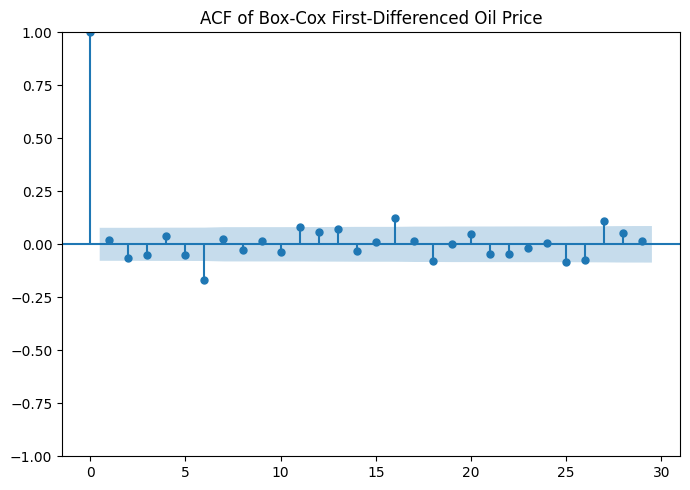

<Figure size 1440x720 with 0 Axes>

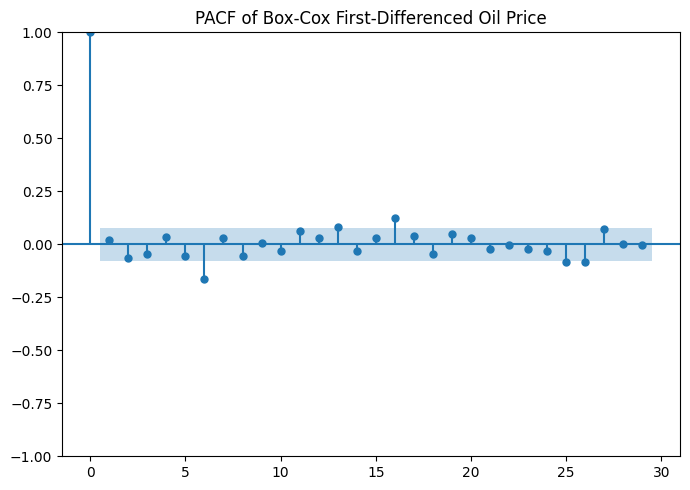

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF
plt.figure(figsize=(10, 5), dpi=144)
plot_acf(data['boxcox_tr_diff'].dropna())
plt.title('ACF of Box-Cox First-Differenced Oil Price')
plt.tight_layout()
plt.show()

# Plot PACF
plt.figure(figsize=(10, 5), dpi=144)
plot_pacf(data['boxcox_tr_diff'].dropna())
plt.title('PACF of Box-Cox First-Differenced Oil Price')
plt.tight_layout()
plt.show()


The PACF plot of the Box-Cox transformed and first-differenced oil price series shows a significant spike at lag 1, with all other lags within the confidence bounds. This pattern suggests that the series can be well modeled with an autoregressive (AR) component of order 1 (i.e., p = 1) in an ARMA model.

# **Define ARMA Model and Find Best Parameters**

# **Grid search for best ARIMA(p,d,q) by AIC**

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

# Create all (p, d, q) combinations with:
# p = 0 to 8
# d = 0, 1, 2
# q = 0 to 8
p_values = range(0, 9)
d_values = [0,1,2]
q_values = range(0, 9)
order_list = list(product(p_values, d_values, q_values))
series = data['Price'].dropna()
# Define function to optimize ARIMA
def optimize_ARIMA(series, order_list):
    results = []
    for order in order_list:
        try:
            model = ARIMA(series, order=order)
            fitted = model.fit()
            results.append({
                'order': order,
                'aic': fitted.aic
            })
            print(f"Fitted ARIMA{order} - AIC: {fitted.aic:.2f}")
        except Exception as e:
            print(f"Skipping ARIMA{order} due to error: {e}")
    return pd.DataFrame(results).sort_values(by='aic').reset_index(drop=True)

# Run optimization
result_df = optimize_ARIMA(series, order_list)

# Show best models
print("\nTop 5 ARIMA models by AIC:")
print(result_df.head())

Fitted ARIMA(0, 0, 0) - AIC: 5825.44
Fitted ARIMA(0, 0, 1) - AIC: 5013.72
Fitted ARIMA(0, 0, 2) - AIC: 4437.31
Fitted ARIMA(0, 0, 3) - AIC: 4004.85
Fitted ARIMA(0, 0, 4) - AIC: 3809.33
Fitted ARIMA(0, 0, 5) - AIC: 3589.74
Fitted ARIMA(0, 0, 6) - AIC: 3468.33
Fitted ARIMA(0, 0, 7) - AIC: 3363.92
Fitted ARIMA(0, 0, 8) - AIC: 4285.01
Fitted ARIMA(0, 1, 0) - AIC: 2831.44
Fitted ARIMA(0, 1, 1) - AIC: 2832.92
Fitted ARIMA(0, 1, 2) - AIC: 2832.55
Fitted ARIMA(0, 1, 3) - AIC: 2830.69
Fitted ARIMA(0, 1, 4) - AIC: 2831.75
Fitted ARIMA(0, 1, 5) - AIC: 2831.42
Fitted ARIMA(0, 1, 6) - AIC: 2814.24
Fitted ARIMA(0, 1, 7) - AIC: 2815.04
Fitted ARIMA(0, 1, 8) - AIC: 2816.94
Fitted ARIMA(0, 2, 0) - AIC: 3248.68
Fitted ARIMA(0, 2, 1) - AIC: 2835.93
Fitted ARIMA(0, 2, 2) - AIC: 2837.39
Fitted ARIMA(0, 2, 3) - AIC: 2837.08
Fitted ARIMA(0, 2, 4) - AIC: 2835.31
Fitted ARIMA(0, 2, 5) - AIC: 2836.32
Fitted ARIMA(0, 2, 6) - AIC: 2836.03
Fitted ARIMA(0, 2, 7) - AIC: 2818.52
Fitted ARIMA(0, 2, 8) - AIC: 2819.43
F

# **Fit Best Model**

In [24]:
# re-define the best fit model variant.
# We do this as the last 'model_fit' recorded will be for the (6,1,7) variant.

from statsmodels.tsa.arima.model import ARIMA

# Fit the best model as per AIC results
best_model = ARIMA(data['Price'].dropna(), order=(6, 1, 7))
best_model_fit = best_model.fit()


In [25]:
#summary of the model
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  634
Model:                 ARIMA(6, 1, 7)   Log Likelihood               -1388.395
Date:                Mon, 07 Jul 2025   AIC                           2804.790
Time:                        11:54:05   BIC                           2867.096
Sample:                             0   HQIC                          2828.986
                                - 634                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0672      0.089      0.752      0.452      -0.108       0.242
ar.L2          0.4336      0.094      4.599      0.000       0.249       0.618
ar.L3          0.0067      0.051      0.131      0.8

The fitted ARIMA(6, 1, 7) model is:

$$
\begin{align*}
y_t' =\ &0.0672\, y_{t-1}' + 0.4336\, y_{t-2}' + 0.0067\, y_{t-3}' \\
&+ 0.5884\, y_{t-4}' - 0.0600\, y_{t-5}' - 0.7046\, y_{t-6}' \\
&- 0.0580\, \varepsilon_{t-1} - 0.5069\, \varepsilon_{t-2} - 0.0963\, \varepsilon_{t-3} \\
&- 0.5684\, \varepsilon_{t-4} + 0.0423\, \varepsilon_{t-5} + 0.6392\, \varepsilon_{t-6} \\
&+ 0.1336\, \varepsilon_{t-7} + \varepsilon_t
\end{align*}
$$


So final time series model.

# **Model Diagnostics Interpretation**

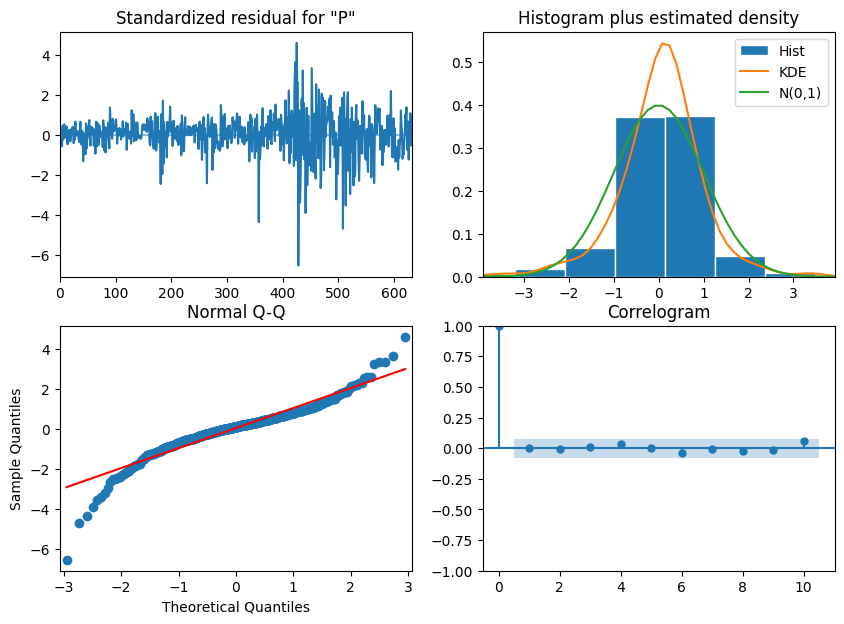

In [26]:
best_model_fit.plot_diagnostics(figsize=(10,7))
plt.show()


In [27]:
#get prediction start and end dates
test_data = data['Price'].dropna()

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#get the predictions and residuals
predictions = best_model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

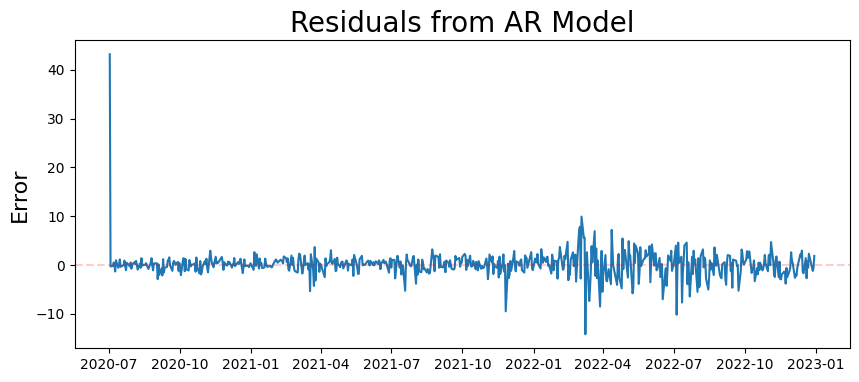

In [28]:
# plot the residuals

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0.5, 0, 'Month')

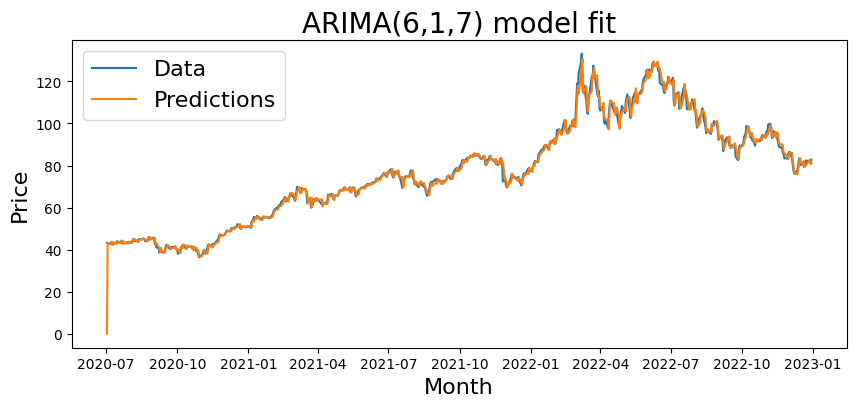

In [29]:
# Plot the model prediction against the data

plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('ARIMA(6,1,7) model fit', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Month', fontsize=16)

In [30]:
import numpy as np

# Calculate RMSE (Root Mean Squared Error) of residuals
rmse = np.sqrt(np.mean(residuals**2))

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')


Root Mean Squared Error (RMSE): 2.7630


# **Forecast 24 Months Ahead with Confidence Intervals**

In [31]:
n_forecast = 24
# Resample daily data to monthly average price
monthly_data = data['Price'].resample('M').mean()
# Drop missing values if any
monthly_data = monthly_data.dropna()
# Get forecast with confidence intervals
forecast_result = best_model_fit.get_forecast(steps=n_forecast)

# Extract forecast mean and confidence intervals
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Create forecast index starting after last observed month
last_date = monthly_data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_forecast, freq='M')

# Assign index to forecast and confidence intervals
forecast_mean.index = forecast_index
conf_int.index = forecast_index


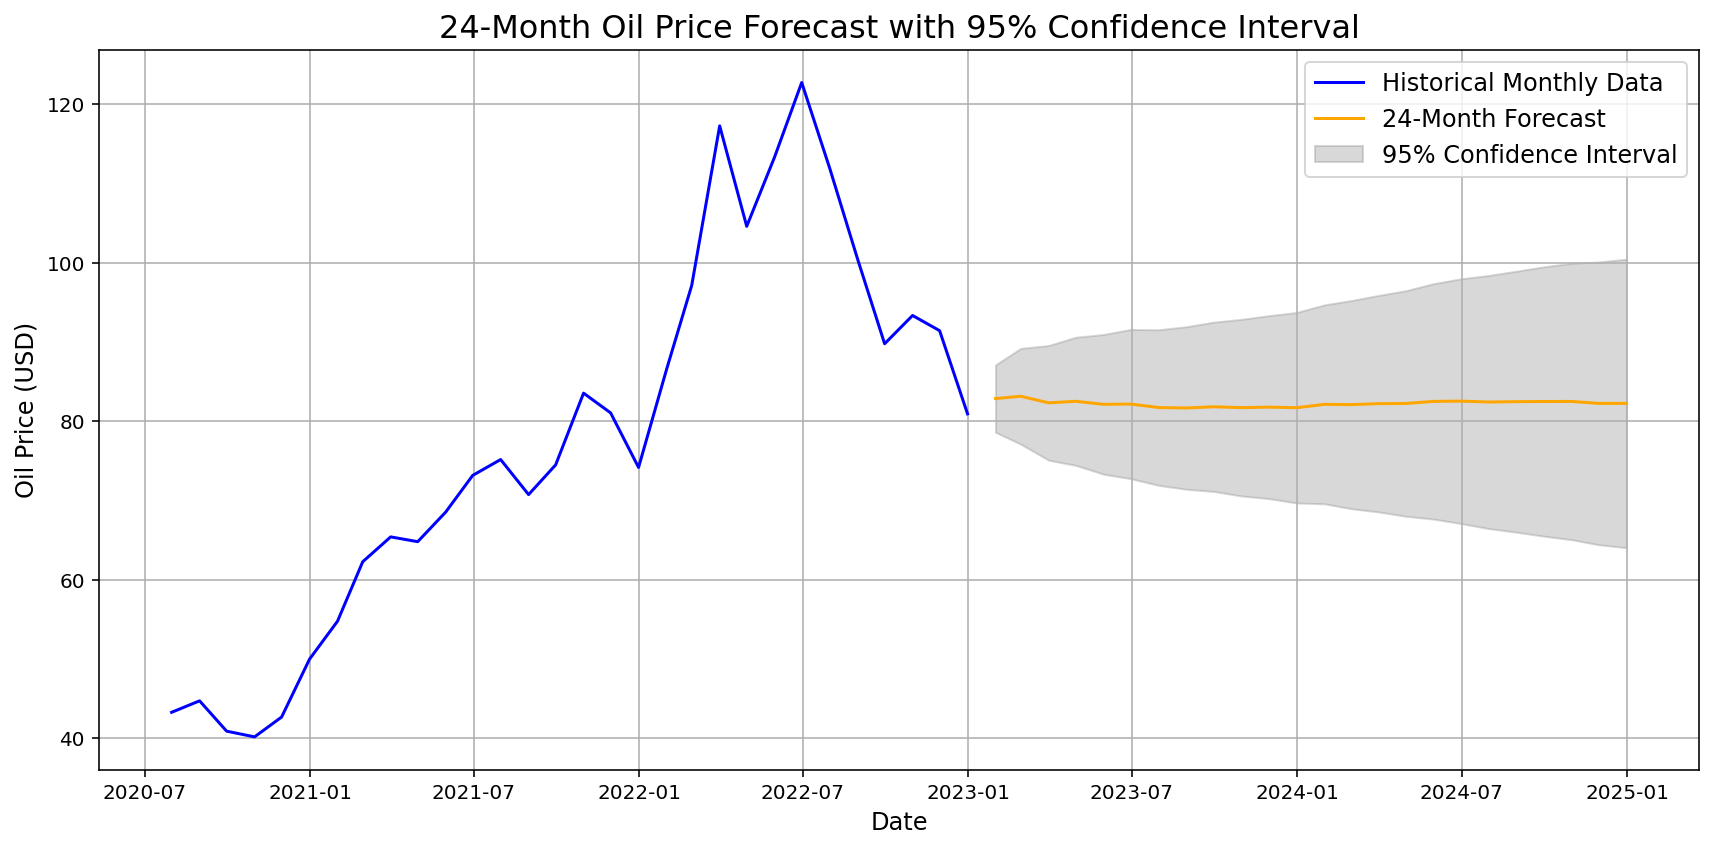

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=144)

# Plot historical monthly data
plt.plot(monthly_data.index, monthly_data, label='Given Monthly Data', color='blue')

# Plot forecast
plt.plot(forecast_mean.index, forecast_mean, label='24-Month Forecast', color='orange')

# Plot confidence intervals as shaded area
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='gray', alpha=0.3, label='95% Confidence Interval')

plt.title('24-Month Oil Price Forecast with 95% Confidence Interval', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Oil Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
# Reconstructing conf_df
# forecast_mean: pd.Series with forecast values
# conf_int: pd.DataFrame with lower/upper confidence intervals

conf_df = pd.concat([
    forecast_mean,           # predicted values, e.g., from forecast.predicted_mean
    conf_int                 # confidence intervals, e.g., from forecast.conf_int()
], axis=1)

# Rename columns if needed
conf_df.columns = ['Predictions', 'Lower CI', 'Upper CI']


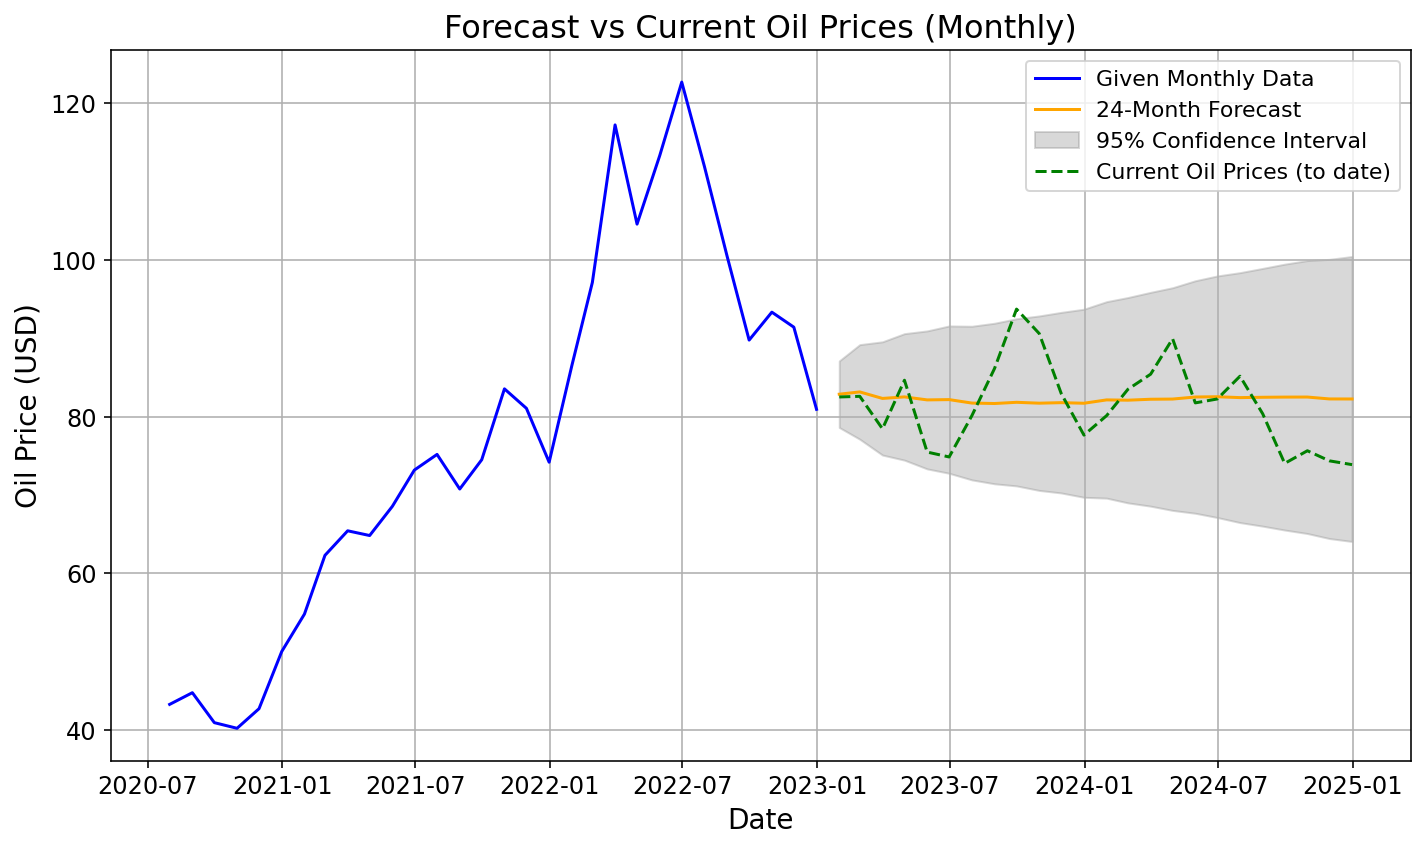

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Historical TRAINING data (define this for 'monthly_data') ---
train_data = pd.read_csv('/content/drive/MyDrive/Advance Research/Assignment 1/oil_price.csv')
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data.set_index('Date', inplace=True)
monthly_data = train_data['Price'].resample('ME').mean()

# --- Latest ACTUAL data ---
actual_data = pd.read_csv('/content/drive/MyDrive/Advance Research/Assignment 1/Oil price data to the current date.csv')
actual_data['Date'] = pd.to_datetime(actual_data['Date'])
actual_data.set_index('Date', inplace=True)
actuals = actual_data['Price'].resample('ME').mean()  # 'ME' fixes the warning

# --- Plot forecast vs actual data ---
plt.figure(figsize=(10, 6), dpi=144)

plt.plot(monthly_data.index, monthly_data.values, label='Given Monthly Data', color='blue')
plt.plot(conf_df.index, conf_df['Predictions'], label='24-Month Forecast', color='orange')
plt.fill_between(conf_df.index, conf_df['Lower CI'], conf_df['Upper CI'],
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# Overlap only forecast/actual period
common_index = conf_df.index.intersection(actuals.index)
plt.plot(actuals.loc[common_index].index, actuals.loc[common_index].values,
         label='Current Oil Prices (to date)', color='green', linestyle='--')

plt.title('Forecast vs Current Oil Prices (Monthly)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Oil Price (USD)', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


### Forecast vs Real Data (ARMA)

The ARMA model predicted a flat oil price trend, while real prices showed more volatility and fluctuations.  
Several actual prices fell outside the 95% confidence interval, showing that the model missed unexpected market changes.  
This highlights ARIMA's limitation in capturing non-linear,real-world dynamics despite statistical soundness.  
Better performance may require advanced models like LSTM that adapt to complex patterns.
